# Urban effects on FPS-SESA simulations


Let's first have a look at the urban fraction as seen by the model. This is land use type 13 (Urban and built-up) in MODIS data.

In [1]:
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar

ProgressBar().register()

MODIS_LAND_USE = {
  'Urban and built-up': 13,
  'Water bodies': 17
}

In [2]:
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/fx/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx'
ds = xr.open_dataset(url)

This loaded all fixed variables information into `ds`. Variables can be accessed as attributes of this object. E.g. land use:

In [3]:
ds.landuse

<xarray.DataArray 'landuse' (lat: 451, lon: 676)>
[304876 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat      (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
Attributes:
    standard_name:  land_cover
    long_name:      Land Cover
    units:          1
    cell_methods:   time: point
    _ChunkSizes:    [50 50]

This is how the common spatial domain looks like (this operation takes some time since some data needs to be retrieved):

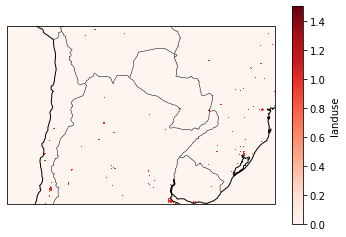

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
from matplotlib import cm

p = (ds.landuse == MODIS_LAND_USE['Urban and built-up']).plot(
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.Reds, vmax = 1.5
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

This is remapped to the regular lon-lat grid. The original extent of the cities is quite similar and in the rotated grid cities such as Buenos Aires are inside the domain. The following code would show it.
```python
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/ncml/CORDEX/output/CSAM-4/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/fx/v20220727/CORDEX_output_CSAM-4_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx_v20220727'
ds = xr.open_dataset(url)
proj = ccrs.RotatedPole(
  pole_longitude=ds.rotated_pole.grid_north_pole_longitude+180,
  pole_latitude=ds.rotated_pole.grid_north_pole_latitude
)
p = (ds.landuse == MODIS_LAND_USE['Urban and built-up']).plot(x='lon', y='lat',
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=proj),
    cmap = cm.viridis_r
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)
```

Major rivers and lakes are also seen by the model at this resolution.

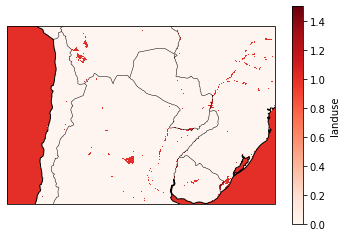

In [5]:
p = (ds.landuse == MODIS_LAND_USE['Water bodies']).plot(
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.Reds, vmax = 1.5
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

## Analysis of minimum temperatures

See https://github.com/jesusff/city_detect/blob/main/RCM_urban_effects.ipynb

In [6]:
var = 'tasmin'
city = 'Buenos Aires'

location = {
  'Buenos Aires': dict(lon=-58.66, lat=-34.49),
  'Porto Alegre': dict(lon=-51.17, lat=-30.03),
}
dlon = dlat = 13

def index_average_n_highest(ds, n = 10):
  ''' Average of n days with the largest tasmin on the city
  
  Averages spatial anomalies with respect to this maximum tasmin
  '''
  rval = (ds[var].isel(time = (ds[var]
    .isel(**{'lon': dlon, 'lat': dlat})
    .argsort()[::-1][:n] # take the n highest
    .values
  )))
  rval = rval - rval.isel(**{'lon': dlon, 'lat': dlat}).values[:,None,None]
  rval = rval.mean(dim='time')
  return(rval)

#
#  Crop area around the city
#
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/day/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_day'
ds = xr.open_dataset(url, chunks = {'lon': 10, 'lat': 10})

ilon = np.argmin((ds['lon'].values-location[city]['lon'])**2)
ilat = np.argmin((ds['lat'].values-location[city]['lat'])**2)
ds_city = ds.isel(
  lat = slice(ilat-dlat,ilat+dlat),
  lon = slice(ilon-dlon,ilon+dlon)
)
ds_city[var]

<xarray.DataArray 'tasmin' (time: 1096, lat: 26, lon: 26)>
dask.array<getitem, shape=(1096, 26, 26), dtype=float32, chunksize=(1096, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -59.16 -59.12 -59.08 -59.04 ... -58.24 -58.2 -58.16
  * lat      (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -34.08 -34.04 -34.0
  * time     (time) datetime64[ns] 2018-06-01T11:30:00 ... 2021-05-31T11:30:00
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: point
    _ChunkSizes:    [ 7 50 50]

Retrieve the data

In [7]:
%%time
ds_city = ds_city.compute()

[########################################] | 100% Completed |  2min 22.1s
CPU times: user 8.93 s, sys: 1.15 s, total: 10.1 s
Wall time: 2min 22s


and plot:

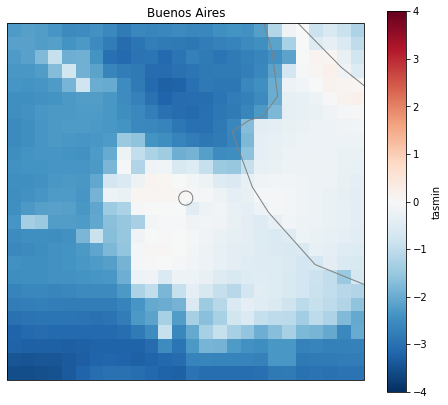

In [8]:
import matplotlib.pyplot as plt

index = index_average_n_highest(ds_city)
proj = ccrs.PlateCarree()
lonlat = ccrs.PlateCarree()
f = plt.figure(figsize=(8,7))
ax = plt.axes(projection=proj)
index.plot.pcolormesh(
  ax=ax, transform=lonlat, cmap=plt.cm.RdBu_r, vmax=4
)
plt.title(city)
ax.coastlines(resolution='50m', linewidth=1, color='gray')
ax.scatter(location[city]['lon'], location[city]['lat'], transform=lonlat, s=200, facecolor='none', edgecolor='grey')
f.savefig(f'{city}.png', facecolor='white')
plt.show()
plt.close('all')


## ERA5

In [9]:
#
#  Crop area around the city
#
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/reanalysis/ERA5-CSAM-4i_day'
ds = xr.open_dataset(url, chunks = {'lon': 10, 'lat': 10})

ilon = np.argmin((ds['lon'].values-location[city]['lon'])**2)
ilat = np.argmin((ds['lat'].values-location[city]['lat'])**2)
ds_city = ds.isel(
  lat = slice(ilat-dlat,ilat+dlat),
  lon = slice(ilon-dlon,ilon+dlon)
)
ds_city[var]

In [10]:
%%time
ds_city = ds_city.compute()

[########################################] | 100% Completed |  5min 28.6s
CPU times: user 17.2 s, sys: 2.42 s, total: 19.6 s
Wall time: 5min 28s


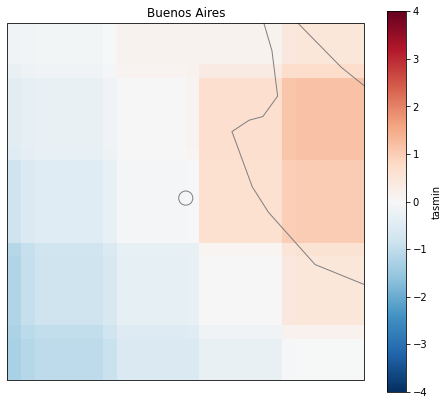

In [11]:
index = index_average_n_highest(ds_city)
proj = ccrs.PlateCarree()
lonlat = ccrs.PlateCarree()
f = plt.figure(figsize=(8,7))
ax = plt.axes(projection=proj)
index.plot.pcolormesh(
  ax=ax, transform=lonlat, cmap=plt.cm.RdBu_r, vmax=4
)
plt.title(city)
ax.coastlines(resolution='50m', linewidth=1, color='gray')
ax.scatter(location[city]['lon'], location[city]['lat'], transform=lonlat, s=200, facecolor='none', edgecolor='grey')
f.savefig(f'{city}.png', facecolor='white')
plt.show()
plt.close('all')

## MSWX

In [ ]:
#
#  Crop area around the city
#
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/observations/CSAM-4i_GloH2O-MSWX_day'
ds = xr.open_dataset(url, chunks = {'lon': 10, 'lat': 10})

ilon = np.argmin((ds['lon'].values-location[city]['lon'])**2)
ilat = np.argmin((ds['lat'].values-location[city]['lat'])**2)
ds_city = ds.isel(
  lat = slice(ilat-dlat,ilat+dlat),
  lon = slice(ilon-dlon,ilon+dlon)
)

In [13]:
%%time
ds_city = ds_city.compute()

[########################################] | 100% Completed |  6min 14.5s
CPU times: user 15.6 s, sys: 2.21 s, total: 17.8 s
Wall time: 6min 14s


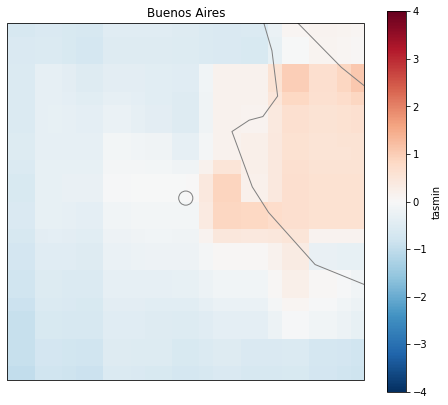

In [14]:
index = index_average_n_highest(ds_city)
proj = ccrs.PlateCarree()
lonlat = ccrs.PlateCarree()
f = plt.figure(figsize=(8,7))
ax = plt.axes(projection=proj)
index.plot.pcolormesh(
  ax=ax, transform=lonlat, cmap=plt.cm.RdBu_r, vmax=4
)
plt.title(city)
ax.coastlines(resolution='50m', linewidth=1, color='gray')
ax.scatter(location[city]['lon'], location[city]['lat'], transform=lonlat, s=200, facecolor='none', edgecolor='grey')
f.savefig(f'{city}.png', facecolor='white')
plt.show()
plt.close('all')